As of 2021-02-27. I have plotted a subset of sessions based on the amount of masking and cells they have. I then looked through each of these plots and determiend which sessions/neurons are best. They are stored on git under figures/2shit, 4shit, 6shit, all hits. See [here](https://docs.google.com/spreadsheets/d/14vj2YuSKi9pSUvye8D5rA6VBCqUm9ezUbh8kaTurJ1I/edit#gid=1622653460) for more info.

In [1]:
# libraries
import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import pickle
# stored one repo up in my fork of Spykes
from spykes.spykes.plot.neurovis import NeuroVis
from io_utils import *
from plotting_utils import * 

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

In [2]:
# pick out sessions/neurons
sess_names = ['data_sdc_20190902_145404_fromSD', 'W122_08_06_2019_1_fromSD', 'W122_08_07_2019_1_fromSD',
             'W122_08_31_2019_1_fromSD', 'W122_09_09_2019_1_fromSD', 'W122_09_21_2019_1_fromSD']

sess_neurons = [[0,1,3], [0,2,3], [0,3], [1,2,3], [0,1], [1]]

# base paths
base_path  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'
fig_save_path = os.path.join(os.getcwd(), 'figures', 'neurovis')


# create specific paths
sess_paths = []
beh_paths = []
spks_paths = []

for sess in range(len(sess_names)):
    sess_path = os.path.join(base_path, sess_names[sess])
    sess_paths.append(sess_path)
    
    beh_paths.append(os.path.join(sess_path, beh_mat))
    spks_paths.append(os.path.join(sess_path, spks_mat))

In [8]:
beh_dfs = []
spks_dicts = []

for sess in range(len(sess_names)):
    beh_df, spks_dict = selective_load_and_wrangle(beh_paths[sess], spks_paths[sess], sess_neurons[sess], overwrite=True)
    beh_dfs.append(beh_df)
    spks_dicts.append(spks_dict)

In [36]:
neurovis_objs = []
for sess in range(len(sess_names)):
    neurons = initiate_neurons(spks_dicts[sess])
    neurovis_objs.append(neurons)

# Plotting all hit trials at aud1, aud2

In [10]:
# Initialize info for plotting
hit_dfs = []

for sess in range(len(sess_names)):
    hit_df = beh_df[beh_df['hit_hist'] == 'hit']
    hit_dfs.append(hit_df)
       

In [24]:
# Deal with masking
sess_bndl_dfs = []
sess_df_names = []

for sess in range(len(sess_names)):
    bndl_dfs, df_names = deal_with_masking(spks_dicts[sess], hit_dfs[sess], sess_paths[sess])
    
    sess_bndl_dfs.append(bndl_dfs)
    sess_df_names.append(df_names)

Loading existing mask_dict...
Done loading.
ngood, first: 127
ngood, second: 134
ngood, second: 134
Loading existing mask_dict...
Done loading.
ngood, first: 104
ngood, second: 114
ngood, second: 114
Loading existing mask_dict...
Done loading.
ngood, first: 187
ngood, second: 200
Loading existing mask_dict...
Done loading.
ngood, first: 125
ngood, second: 130
ngood, second: 130
Loading existing mask_dict...
Done loading.
ngood, second: 227
ngood, second: 227
Loading existing mask_dict...
Done loading.
ngood, second: 60


In [61]:
# plot settings
events = ['aud1_on','aud2_on']
event_names = ['aud1_on', 'aud2_on']
windows = [[-500,1000], [-500, 700]]

In [37]:
# create rasters & psths

sess_rasters = []
sess_psths = []

for sess in range(len(sess_names)):
    sess_rasters.append(get_neuron_rasters(neurovis_objs[sess], events, windows, sess_bndl_dfs[sess], sess_df_names[sess]))
    sess_psths.append(get_neuron_psths(neurovis_objs[sess], events, windows, sess_bndl_dfs[sess], sess_df_names[sess]))

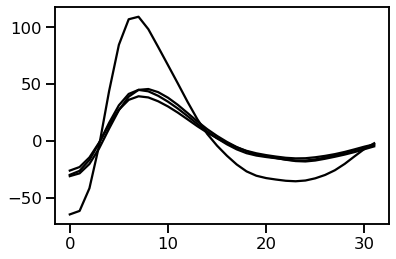

In [48]:
plt.plot(spks_dicts[0]['mean_wav'][0].T, color = 'black')

In [63]:
for sess in range(len(sess_names)):
    
    for nn in range(len(neurovis_objs[sess])):

        # grab mean waveform for the neuron
        mean_wav = spks_dicts[sess]['mean_wav'][nn]

        # iterate over event
        for ee in range(len(events)):

            # initilaize plot
            fig = plt.figure(figsize=(18,12))
            ax1 = plt.subplot2grid((4, 3), (0, 0), rowspan=2, colspan=2)
            ax2 = plt.subplot2grid((4, 3), (2, 0), rowspan=2, colspan=2)
            ax3 = plt.subplot2grid((4, 3), (1, 2), rowspan=2, colspan=1)

            # plot raster and psth for each sess, neuron, event
            neurovis_objs[sess][nn].plot_raster(sess_rasters[sess][nn][ee], axis=ax1, event_name=events[ee], cmap="Greys")
            neurovis_objs[sess][nn].plot_psth(sess_psths[sess][nn][ee],axis=ax2, event_name=events[ee])

            # plot average waveform from active tetrode
            for tt in range(4):
                ax3.plot(mean_wav[tt], color = 'black' )
                ax3.set_title('Average Waveform')

            fig_name = "{n_sess}_{date}_neuron_{num}_{event}".format(n_sess = sess,
                                                                     date = spks_dicts[sess]['date'],
                                                                     num = spks_dicts[sess]['neuron_nums'][nn], 
                                                                     event = event_names[ee])
            # format & save out
            plt.tight_layout()
            plt.savefig(os.path.join(fig_save_path, 'all_hits', fig_name))
            plt.close("all")